In [ ]:
'''
jupyter notebook for preparing visuals and figures for final presentation and report on-the-fy
'''

In [1]:
# colab needs one package not installed by default for vxm library
!pip install pystrum

  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19533 sha256=bae6659e964d01ff6381464bf99c1d7a411dd36eb173af199f7597f3081180c5
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
import os, sys
import glob
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/My Drive/EC500')

import vxm_torch as vxm

Mounted at /content/drive


In [3]:
save_dir = '/content/drive/My Drive/EC500/figures'

# Create and save plots of loss functions, Dice score

In [44]:
# set the file to load and description for saved output file
load_file1 = '/content/drive/My Drive/EC500/atlas_models/pretrained_reg/model_eval/dice_data.npy'
load_file2 = '/content/drive/My Drive/EC500/atlas_models/pretrained_reg/model_eval/dice_no_bg_data.npy'
file_data = 'pretrained_atlas_dice'

save_path = os.path.join(save_dir, file_data)

data1 = np.load(load_file1)
data2 = np.load(load_file2)

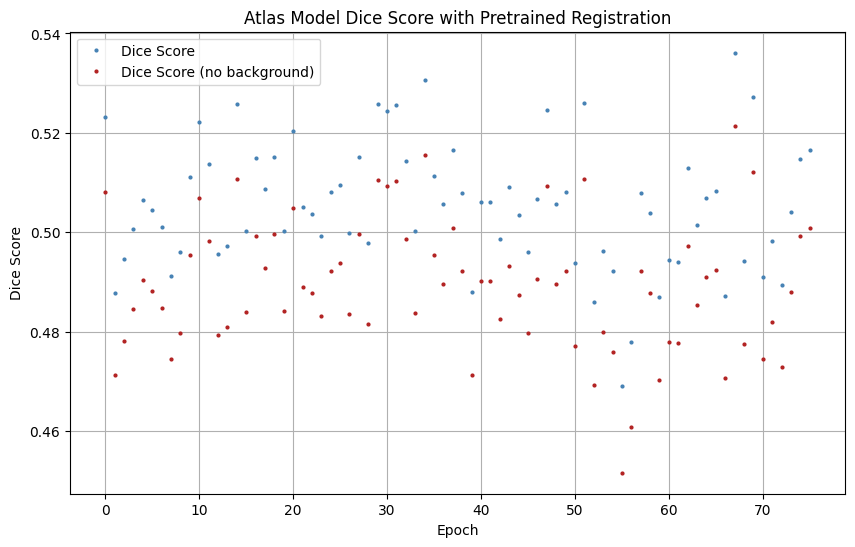

In [45]:
x_values = np.arange(len(data1))

plt.figure(figsize=(10, 6))
plt.plot(x_values, data1, marker='o', markersize=2, linestyle='', color='steelblue', label='Dice Score')
plt.plot(x_values, data2, marker='o', markersize=2, linestyle='', color='firebrick', label='Dice Score (no background)')
plt.title('Atlas Model Dice Score with Pretrained Registration')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

# Save the plot as a jpg file
plt.savefig(save_path, dpi=500, format='jpg')

# Display the plot
plt.show()

# Produce registration and segmentation pair videos

In [53]:
# prepare filepaths for loading, saving sample image registration data
ground_truth = '/content/drive/My Drive/EC500/atlas_models/pretrained_reg/model_eval/sample_dict.npz'
moving = '/content/drive/My Drive/EC500/atlas_models/pretrained_reg/model_eval/moved_samples_dict.npz'
#flow = '/content/drive/My Drive/EC500/reg_models/model_eval/flows_dict.npz'

file_data = 'pretrained_atlas_sample_vid.mp4'
save_path = os.path.join(save_dir, file_data)

In [54]:
# load image, segmentation dictionaries
ground_truth_dict = np.load(ground_truth, allow_pickle=True)
moving_dict = np.load(moving, allow_pickle=True)
#flows_dict = np.load(flow, allow_pickle=True)

samples = [ground_truth_dict['sample1'], ground_truth_dict['sample2']]
segs = [ground_truth_dict['segsample1'], ground_truth_dict['segsample2']]

moving_samples = [moving_dict['sample1_moved']] #, moving_dict['sample2_moved']]
moving_segs = [moving_dict['segsample1_moved']] #, moving_dict['segsample2_moved']]

#flows = flows_dict['flow']

In [28]:
def bgr_image(image):
    '''
    given an input grayscale image, convert to np.uint bgr in range [0, 255]
    '''

    image = (image*255).astype(np.uint8)
    image = cv2.merge([image, image, image])

    return image

def bgr_segmentation(segs):
    '''
    given an input segmentation map, convert to np.uint bgr in range [0, 255]
    and apply nipy_spectral colormap
    '''

    norm_segs = segs/24.0

    colormap = plt.get_cmap('nipy_spectral')
    rgba_segs = colormap(norm_segs)
    rgb_segs = (rgba_segs[:, :, :3] * 255).astype(np.uint8)
    bgr_segs = cv2.cvtColor(rgb_segs, cv2.COLOR_RGB2BGR)

    return bgr_segs


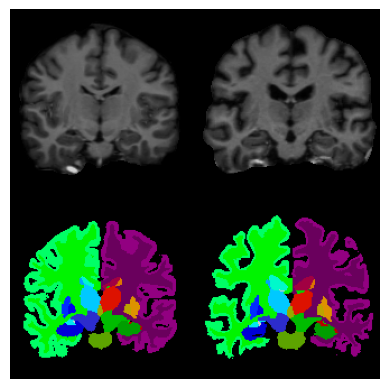

In [55]:
# stack the ground truth samples, segmentations

# horizontally stack samples
top = np.hstack((samples[0], np.zeros((samples[0].shape[0], 10)), samples[1]))

# reformat as 3-channel image with np.uint8 datatype for cv2
top = bgr_image(top)


# horizontally stack segmentations
bottom = np.hstack((segs[0], np.zeros((segs[0].shape[0], 10)), segs[1]))

# apply colormap to segmentation and convert to BGR
bottom = bgr_segmentation(bottom)


# vertically stack samples, segmentations
stack = np.vstack((top, np.zeros((10, samples[0].shape[1] + segs[0].shape[1] + 10, 3), dtype=np.uint8), bottom))

# preview the image
plt.imshow(stack)
plt.axis('off')

plt.show()

In [56]:
# place the moving images and segmentations beside the fixed ones for both directions
# save each epoch sample to list

frames = []

num_frames = moving_samples[0].shape[0]

for ii in range(num_frames):

    # get the images and convert to bgr
    sample1_moved = bgr_image(moving_samples[0][ii])
    #sample2_moved = bgr_image(moving_samples[1][ii])

    # get the segmentations and convert to bgr
    seg1_moved = bgr_segmentation(moving_segs[0][ii])
    #seg2_moved = bgr_segmentation(moving_segs[1][ii])


    # stack the image and segmentation pairs vertically

    pad = np.zeros((10, sample1_moved.shape[1], 3), dtype=np.uint8)
    sample1_stack = np.vstack((sample1_moved, pad, seg1_moved))
    #sample2_stack = np.vstack((sample2_moved, pad, seg2_moved))

    # stack with the ground truth horizontally

    pad = np.zeros((stack.shape[0], 10, 3), dtype=np.uint8)
    #frame_stack = np.hstack((sample2_stack, pad, stack, pad, sample1_stack))
    frame_stack = np.hstack((stack, pad, sample1_stack))

    frames.append(frame_stack)


In [44]:
def record_registration_video(frame_list, save_path, frame_rate=2):

    # initialize cv2 video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    shape = frame_list[0].shape
    video_writer = cv2.VideoWriter(save_path, fourcc, frame_rate, (shape[1], shape[0]))

    # get each atlas and write to the video
    for i, frame in enumerate(frame_list):

       video_writer.write(frame)

    # release the video writer
    video_writer.release()

    print(f'{i + 1} frames recorded')

In [57]:
record_registration_video(frames, save_path)

76 frames recorded


# Produce atlas progression videos

In [ ]:
def get_atlas(nn_path, save_imgpath=None, filetype='jpg'):
    '''
    return a numpy array from a VxmAtlas layer, optionally save image file
    '''

    # load instance of the trained atlas layer
    atlas_model = vxm.myutils.VxmAtlas.load(path=nn_path, device='cpu')

    # detatch the atlas parameter and convert
    atlas_data = atlas_model.atlas_layer.atlas
    atlas_data = atlas_data.detach().squeeze().numpy()

    if save_imgpath is not None:
        plt.imsave((save_imgpath + '.' + filetype), atlas_data, cmap='gray', format=filetype)

    return atlas_data

In [ ]:
def record_atlas_video(model_paths, save_path, frame_rate=2, shape=(160, 160)):
    '''
    given a list of atlas checkpoints, save an .mp4 showing the progression of each updated model
    '''

    # initialize cv2 video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(save_path, fourcc, frame_rate, shape)

    # get each atlas and write to the video
    for i, frame in enumerate(model_paths):

        frame_data = get_atlas(frame)

        # normalize to range [0, 255] in np.uint8, convert to 3-channel BGR
        frame_normalized = (frame_data - np.min(frame_data)) / (np.max(frame_data) - np.min(frame_data))
        frame_uint8 = (frame_normalized * 255).astype(np.uint8)
        frame_bgr = cv2.cvtColor(frame_uint8, cv2.COLOR_GRAY2BGR)

        video_writer.write(frame_bgr)

    # release the video writer
    video_writer.release()

    print(f'{i + 1} frames recorded')

In [ ]:
# load atlas models, set paths to save video
atlas_path = '/content/drive/My Drive/EC500/atlas_models/pretrained_reg/atlas'

file_data = 'pretrained_atlas_video.mp4'
save_path = os.path.join(save_dir, file_data)

# Get all file paths in the folder
model_paths = glob.glob(os.path.join(atlas_path, '*.pt'))

# Sort the list if needed
model_paths.sort()

In [ ]:
record_atlas_video(model_paths=model_paths, save_path=save_path)

/content/drive/My Drive/EC500/vxm_torch/modelio.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=torch.device(device))


75 frames recorded
